In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
crypto_df = pd.read_csv('../data/cryptocurrency.csv')
stocks_df = pd.read_csv('../data/stocks.csv')

main_df = pd.concat([crypto_df,stocks_df])[['subreddit','selftext','title']]
main_df.reset_index(inplace=True)
main_df.drop(labels='index', inplace=True, axis=1)

In [3]:
main_df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

### Data Cleaning

In [4]:
main_df.head()

,subreddit,selftext,title
0,CryptoCurrency,"I'm pretty new to crypto, just got in this yea...","Not Your Keys, Not Your Coin"
1,CryptoCurrency,Coinbase will not be launching its crypto lend...,The SEC bullied coinbase into dropping their 4...
2,CryptoCurrency,I strongly believe Ryan Reynolds and Rob McElh...,Wrexham Football Club as a DAO
3,CryptoCurrency,You will want to take your ALGOs off any excha...,"ALGO hodlers, don't forget governance starts O..."
4,CryptoCurrency,"If you're bringing up mobile phones, smart dev...",Blockchain's relevance- The link between milit...


In [5]:
main_df.tail()

,subreddit,selftext,title
2025,stocks,Hi all -- I'm hoping for help understanding wh...,Help requested: What is my 401(k) invested in?
2026,stocks,Obviously tobacco consumption has declined con...,Looking to get into weed/vape/tobacco companie...
2027,stocks,Hey guys. I have been using free tools until n...,What tools/services are worth paying for?
2028,stocks,What happens to stocks when the company goes b...,Can hedge funds or retail still own stock in a...
2029,stocks,I have 40k in my Charles Schwab account. My I...,Another annoying question about what I should ...


#### Initialise helper methods for data cleaning and confusion matrix plotting

In [8]:
def clean_data(data):
    url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)(;\w+.?\w+)?'
    num_regex = r'\d+'
    word_regex = r"(\w+'*\w+)"#r'[A-Za-z]+'
    non_word_regex = r'(\&amp)[&;â€œ™,.]'
    x = re.sub(url_regex,'',data)
    x = re.sub(num_regex,'',x)
    word_tokenizer = RegexpTokenizer(word_regex)
    x = word_tokenizer.tokenize(x.lower())
    tokenizer = RegexpTokenizer(r'[?!\W+]')
    tmp_lst = list(filter(None,[re.sub(non_word_regex,'',i) for i in x]))
    lemmatizer = WordNetLemmatizer()
    lemma_tmp = [lemmatizer.lemmatize(tok) for tok in tmp_lst]
#     p_stemmer = PorterStemmer()
#     stem_tmp = [p_stemmer.stem(tok) for tok in tmp_lst]
    return ' '.join(lemma_tmp)

In [126]:
def metrics_and_plot_cm(classifier, X, y):
    preds = classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    misclass = 1 - acc
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    results = {
        'Accuracy': acc,
        'Misclassification Rate': misclass,
        'Sensitivity': sens,
        'Specificity': spec,
        'Precision': prec
    }
    metrics = pd.DataFrame({
        'Metric': results.keys(),
        'Score': results.values()
        })
    plot_confusion_matrix(classifier, X, y, cmap='Blues', values_format='d');
    return metrics

#### Merge selftext and title as a combined feature to use as X

In [10]:
main_df['selftext_title'] = main_df['selftext'] + main_df['title']

In [11]:
main_df['selftext_title'] = main_df['selftext_title'].apply(clean_data)

In [12]:
main_df

,subreddit,selftext,title,selftext_title
0,CryptoCurrency,"I'm pretty new to crypto, just got in this yea...","Not Your Keys, Not Your Coin",i'm pretty new to crypto just got in this year...
1,CryptoCurrency,Coinbase will not be launching its crypto lend...,The SEC bullied coinbase into dropping their 4...,coinbase will not be launching it crypto lendi...
2,CryptoCurrency,I strongly believe Ryan Reynolds and Rob McElh...,Wrexham Football Club as a DAO,strongly believe ryan reynolds and rob mcelhen...
3,CryptoCurrency,You will want to take your ALGOs off any excha...,"ALGO hodlers, don't forget governance starts O...",you will want to take your algos off any excha...
4,CryptoCurrency,"If you're bringing up mobile phones, smart dev...",Blockchain's relevance- The link between milit...,if you're bringing up mobile phone smart devic...
...,...,...,...,...
2025,stocks,Hi all -- I'm hoping for help understanding wh...,Help requested: What is my 401(k) invested in?,hi all i'm hoping for help understanding what ...
2026,stocks,Obviously tobacco consumption has declined con...,Looking to get into weed/vape/tobacco companie...,obviously tobacco consumption ha declined cons...
2027,stocks,Hey guys. I have been using free tools until n...,What tools/services are worth paying for?,hey guy have been using free tool until now as...
2028,stocks,What happens to stocks when the company goes b...,Can hedge funds or retail still own stock in a...,what happens to stock when the company go bank...


#### Map results of subreddit to 1 and 0

In [13]:
main_df['subreddit'] = main_df['subreddit'].map({'CryptoCurrency':1, 'stocks':0})
# main_df['subreddit'] = main_df['subreddit'].map({'CryptoCurrency':1, 'wallstreetbets':0})

In [14]:
X = main_df['selftext_title']
y = main_df['subreddit']

In [15]:
y.value_counts(normalize=True)

0    0.500985
1    0.499015
Name: subreddit, dtype: float64

#### Stopwords

In [16]:
eng_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
self_def_stopwords = ['cryptocurrency','crypto','stocks','stock','amp','share','like','just','make','shares','market','buy','people','time','don','money','price','companies','company','new','know','bitcoin','ethereum','ve','coin','btc','eth','long','day','good','year','think','going','gt','want', 'dip', 'news', 'years', 'sell','need', 'week','blockchain','coins','lot','said','term','way','use','trading','ha','wa','thi']
list_of_stopwords = eng_stopwords + self_def_stopwords

#### TODO: Create function to take in and compare words from Lemmatizer and Stemmer
Show 2 charts side by side for comparison. <br>
Explain choice of lemmatising vs stemmer

In [17]:
cvec = CountVectorizer(stop_words=list_of_stopwords)

In [18]:
sample = cvec.fit_transform(X)

In [19]:
sample_df = pd.DataFrame(sample.todense(), columns=cvec.get_feature_names())

<AxesSubplot:>

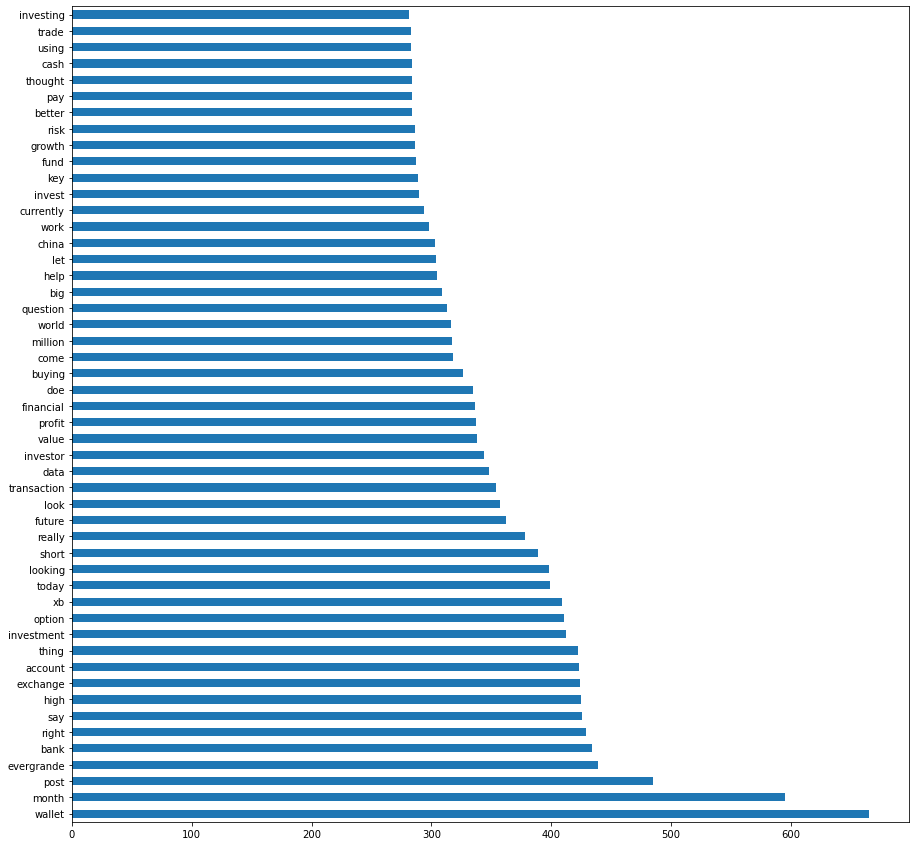

In [20]:
plt.figure(figsize=(15,15))
sample_df.sum().sort_values(ascending=False).head(50).plot(kind='barh')

In [21]:
tvec = TfidfVectorizer(stop_words=list_of_stopwords)

In [22]:
sample = tvec.fit_transform(X)

In [23]:
sample_df = pd.DataFrame(sample.todense(), columns=tvec.get_feature_names())

<AxesSubplot:>

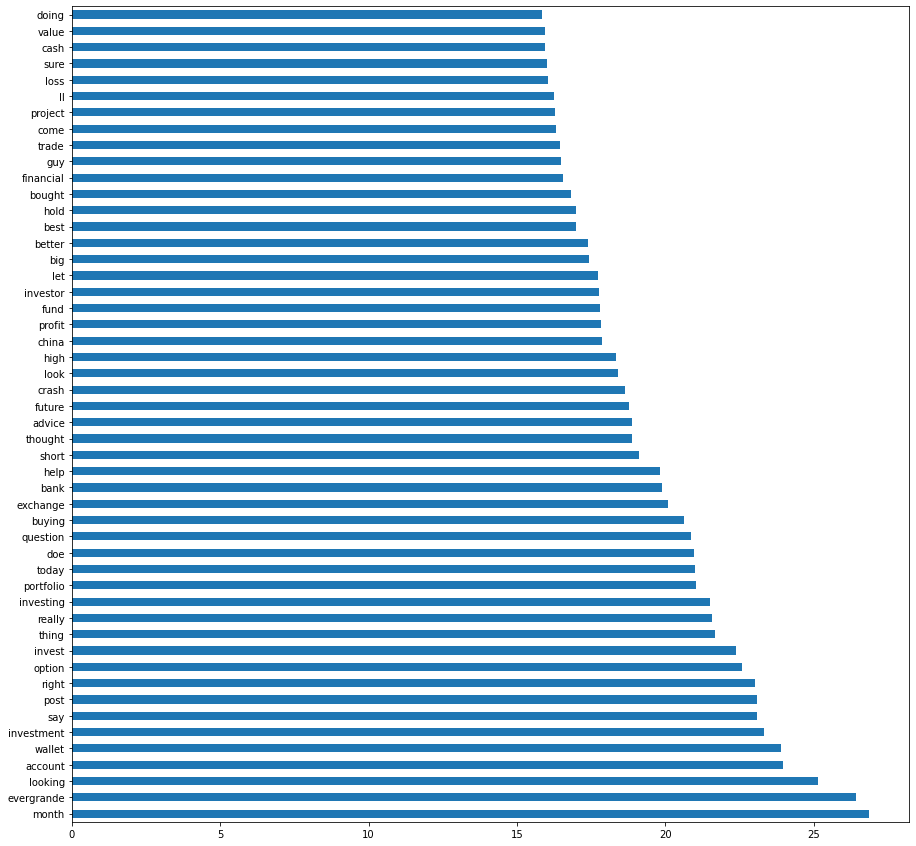

In [24]:
plt.figure(figsize=(15,15))
sample_df.sum().sort_values(ascending=False).head(50).plot(kind='barh')

### Train Test and Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [26]:
cvec = CountVectorizer(stop_words=list_of_stopwords, ngram_range=(1,2))
cvec.fit(X_train)

CountVectorizer(ngram_range=(1, 2),
                stop_words=['find', 'meanwhile', 'hereupon', 'over', 'everyone',
                            'twelve', 'throughout', 'most', 'and', 'made',
                            'keep', 'beforehand', 'ourselves', 'show',
                            'whereby', 'fill', 'his', 'is', 'hereafter',
                            'somewhere', 'formerly', 'put', 'more', 'indeed',
                            'these', 'became', 'former', 'get', 'give',
                            'whence', ...])

In [27]:
X_train_sc = cvec.transform(X_train)

In [28]:
X_train_sc

<1624x116483 sparse matrix of type '<class 'numpy.int64'>'
	with 222209 stored elements in Compressed Sparse Row format>

In [29]:
X_train_df = pd.DataFrame(X_train_sc.todense(),
                         columns=cvec.get_feature_names())

In [30]:
X_train_df.sum().sort_values(ascending=False).head(40).index

Index(['wallet', 'month', 'post', 'option', 'evergrande', 'bank', 'exchange',
       'investment', 'thing', 'say', 'right', 'high', 'account', 'short',
       'really', 'xb', 'today', 'looking', 'transaction', 'future', 'look',
       'investor', 'financial', 'profit', 'buying', 'doe', 'million',
       'question', 'come', 'value', 'world', 'invest', 'currently', 'help',
       'fund', 'china', 'trade', 'work', 'pay', 'let'],
      dtype='object')

<AxesSubplot:>

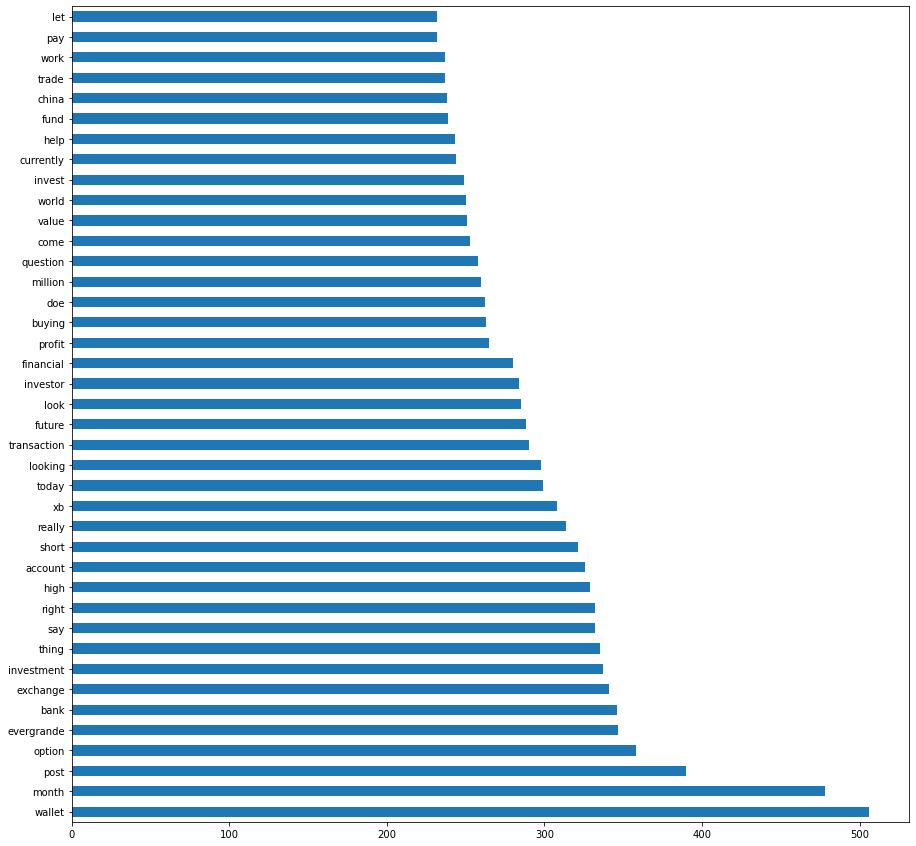

In [31]:
plt.figure(figsize=(15,15))
X_train_df.sum().sort_values(ascending=False).head(40).plot(kind='barh')

### Logistic Regression

#### CountVectorizer with Logistic Regression

In [171]:
pipe_cvec_logreg = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression()),
])

In [172]:
# pipe_logreg_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85,.9,.95],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
# }


pipe_cvec_logreg_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,2)],
}

In [173]:
gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, param_grid=pipe_cvec_logreg_params, cv=5)

In [174]:
gs_cvec_logreg.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [175]:
gs_cvec_logreg.best_score_

0.872539411206078

In [176]:
gs_cvec_logreg.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2)}

In [177]:
gs_cvec_logreg.score(X_train,y_train)

0.9926108374384236

In [178]:
gs_cvec_logreg.score(X_test, y_test)

0.8916256157635468

,Metric,Score
0,Accuracy,0.891626
1,Misclassification Rate,0.108374
2,Sensitivity,0.886700
3,Specificity,0.896552
4,Precision,0.895522


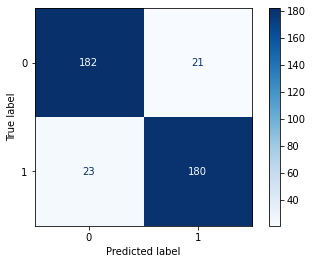

In [179]:
metrics_and_plot_cm(gs_cvec_logreg,X_test, y_test)

#### TFIDF Vectorizer with Logistic Regression

In [180]:
pipe_tvec_logreg = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('logreg',LogisticRegression()),
])

In [181]:
# pipe_logreg_tvec_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [2,3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
# }

pipe_tvec_logreg_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.85],
    'tvec__ngram_range': [(1,3)],
}

In [182]:
gs_tvec_logreg = GridSearchCV(pipe_tvec_logreg, param_grid=pipe_tvec_logreg_params, cv=5)

In [183]:
%%time
gs_tvec_logreg.fit(X_train,y_train)

Wall time: 2.62 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [184]:
gs_tvec_logreg.best_score_

0.8879449192782527

In [185]:
gs_tvec_logreg.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [186]:
gs_tvec_logreg.score(X_train,y_train)

0.9618226600985221

In [187]:
gs_tvec_logreg.score(X_test, y_test)

0.9064039408866995

,Metric,Score
0,Accuracy,0.906404
1,Misclassification Rate,0.093596
2,Sensitivity,0.901478
3,Specificity,0.911330
4,Precision,0.910448


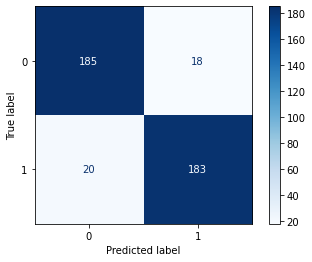

In [188]:
metrics_and_plot_cm(gs_tvec_logreg,X_test, y_test)

#### CountVectorizer with k-NN Classifier

In [189]:
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [190]:
# pipe_cvec_knn_params = {
#     'cvec__max_features': [None,2000,3000,4000,5000],
#     'cvec__min_df': [2,3],
#     'cvec__max_df': [.85],
#     'cvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'knn__n_neighbors': [5,6,7,8,9,10],

# }

pipe_cvec_knn_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.85],
    'cvec__ngram_range': [(1,1)],
    'knn__n_neighbors': [13],

}



In [191]:
gs_cvec_knn = GridSearchCV(pipe_cvec_knn, param_grid=pipe_cvec_knn_params, cv=5, verbose=1)

In [192]:
%%time
gs_cvec_knn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.02 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [193]:
gs_cvec_knn.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'knn__n_neighbors': 13}

In [194]:
gs_cvec_knn.score(X_train, y_train)

0.646551724137931

In [195]:
gs_cvec_knn.score(X_test,y_test)

0.5197044334975369

,Metric,Score
0,Accuracy,0.519704
1,Misclassification Rate,0.480296
2,Sensitivity,0.571429
3,Specificity,0.467980
4,Precision,0.517857


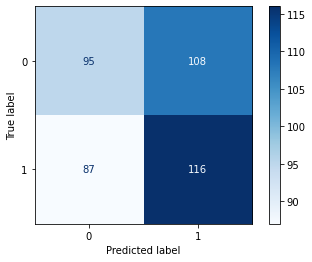

In [196]:
metrics_and_plot_cm(gs_cvec_knn,X_test, y_test)

#### TFIDF Vectorizer with k-NN Classifier

In [211]:
pipe_tvec_knn = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('knn',KNeighborsClassifier()),
])

In [212]:
pipe_tvec_knn_params = {
    'tvec__max_features': [None],
     'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'knn__n_neighbors': [13],

}

In [213]:
gs_tvec_knn = GridSearchCV(pipe_tvec_knn, param_grid=pipe_tvec_knn_params, cv=5, verbose=1)

In [214]:
%%time
gs_tvec_knn.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.02 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [215]:
gs_tvec_knn.best_params_

{'knn__n_neighbors': 13,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [216]:
gs_tvec_knn.best_score_

0.8146571699905033

In [217]:
gs_tvec_knn.score(X_train, y_train)

0.8565270935960592

In [218]:
gs_tvec_knn.score(X_test, y_test)

0.8399014778325123

,Metric,Score
0,Accuracy,0.839901
1,Misclassification Rate,0.160099
2,Sensitivity,0.871921
3,Specificity,0.807882
4,Precision,0.819444


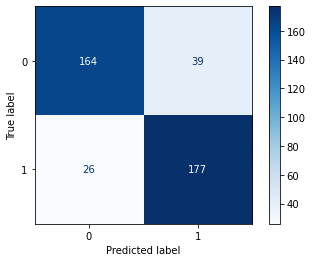

In [210]:
metrics_and_plot_cm(gs_tvec_knn,X_test, y_test)

#### Using CountVectorizer with Naive Bayes

In [224]:
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [225]:
pipe_cvec_nb_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'nb__alpha':[0.25]
}

In [226]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, param_grid=pipe_cvec_nb_params, cv=5, verbose=1)

In [227]:
%%time
gs_cvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.72 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [228]:
print(gs_cvec_nb.best_score_)

0.8725508072174737


In [229]:
gs_cvec_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.25}

In [230]:
gs_cvec_nb.score(X_train, y_train)

0.9144088669950738

In [231]:
gs_cvec_nb.score(X_test,y_test)

0.874384236453202

,Metric,Score
0,Accuracy,0.874384
1,Misclassification Rate,0.125616
2,Sensitivity,0.926108
3,Specificity,0.822660
4,Precision,0.839286


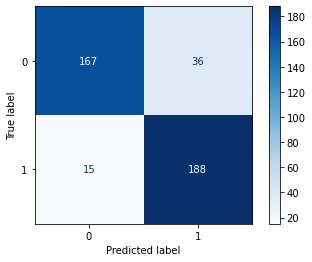

In [233]:
metrics_and_plot_cm(gs_cvec_nb,X_test, y_test)

#### Using TFIDF Vectorizer with Naive Bayes Classifier

In [234]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('nb', MultinomialNB())
])

In [235]:
# pipe_tvec_nb_params = {
#     'tvec__max_features': [None,2000,3000,4000],
#     'tvec__min_df': [.2],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'nb__alpha':[0.1,1,10]
# }

pipe_tvec_nb_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'nb__alpha':[0.1]
}


In [236]:
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, param_grid=pipe_tvec_nb_params, cv=5, verbose=1)

In [237]:
%%time
gs_tvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 931 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [238]:
gs_tvec_nb.score(X_train,y_train)

0.9341133004926109

In [239]:
gs_tvec_nb.score(X_test, y_test)

0.8768472906403941

In [240]:
gs_tvec_nb.best_score_

0.8817891737891739

,Metric,Score
0,Accuracy,0.876847
1,Misclassification Rate,0.123153
2,Sensitivity,0.911330
3,Specificity,0.842365
4,Precision,0.852535


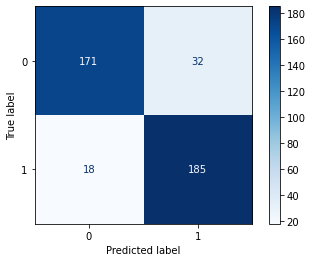

In [242]:
metrics_and_plot_cm(gs_tvec_nb,X_test, y_test)

#### Using CountVectorizer with DecisionTreeClassifier

In [243]:
pipe_cvec_tree = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier())
])

In [244]:
pipe_cvec_tree_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1)],
    'tree__max_depth': [None],
    'tree__min_samples_split': [30],
    'tree__min_samples_leaf': [5],
    'tree__ccp_alpha': [0.001]
}

In [245]:
gs_cvec_tree = GridSearchCV(estimator=pipe_cvec_tree, 
                            param_grid=pipe_cvec_tree_params,
                            cv=5,
                            verbose=1)

In [246]:
%%time
gs_cvec_tree.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.17 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [247]:
gs_cvec_tree.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'tree__ccp_alpha': 0.001,
 'tree__max_depth': None,
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 30}

In [248]:
gs_cvec_tree.best_score_

0.7623285849952517

In [249]:
gs_cvec_tree.score(X_train, y_train)

0.8848522167487685

In [250]:
gs_cvec_tree.score(X_test, y_test)

0.8226600985221675

,Metric,Score
0,Accuracy,0.822660
1,Misclassification Rate,0.177340
2,Sensitivity,0.802956
3,Specificity,0.842365
4,Precision,0.835897


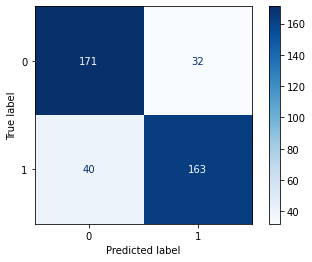

In [251]:
metrics_and_plot_cm(gs_cvec_tree,X_test, y_test)

#### Using TFIDFVectorizer with DecisionTreeClassifier

In [252]:
pipe_tvec_tree = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('tree', DecisionTreeClassifier())
])

In [253]:
# pipe_tree_params = {
#     'tvec__max_features': [None],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2)],
#     'tree__max_depth': [None],
#     'tree__min_samples_split': [5,10,15,20],
#     'tree__min_samples_leaf': [2,3,4,5,6],
#     'tree__ccp_alpha': [0,0.001,0.01,0.1,1,10]
# }

pipe_tvec_tree_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)],
    'tree__max_depth': [None],
    'tree__min_samples_split': [30],
    'tree__min_samples_leaf': [2],
    'tree__ccp_alpha': [0.001]
}

In [254]:
gs_tvec_tree = GridSearchCV(estimator = pipe_tvec_tree,
                      param_grid=pipe_tvec_tree_params,
                      cv=5,
                      verbose=1
                     )

In [255]:
%%time
gs_tvec_tree.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1.57 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [256]:
gs_tvec_tree.best_params_

{'tree__ccp_alpha': 0.001,
 'tree__max_depth': None,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 30,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [257]:
gs_tvec_tree.best_score_

0.756773029439696

In [258]:
gs_tvec_tree.score(X_train, y_train)

0.9359605911330049

In [259]:
gs_tvec_tree.score(X_test, y_test)

0.8374384236453202

,Metric,Score
0,Accuracy,0.837438
1,Misclassification Rate,0.162562
2,Sensitivity,0.881773
3,Specificity,0.793103
4,Precision,0.809955


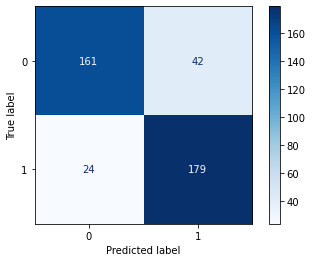

In [260]:
metrics_and_plot_cm(gs_tvec_tree,X_test, y_test)

#### Using CountVectorizer with Bagging

In [261]:
pipe_cvec_bag = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(bootstrap=True))
])

In [262]:
# Best params found
pipe_cvec_bag_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)],
    'bag__n_estimators': [40],
}

In [263]:
gs_cvec_bag = GridSearchCV(estimator = pipe_cvec_bag,
                      param_grid=pipe_cvec_bag_params,
                      cv=5,
                      verbose=1
                     )

In [264]:
%%time
gs_cvec_bag.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 15.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [265]:
gs_cvec_bag.best_params_

{'bag__n_estimators': 40,
 'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2)}

In [266]:
gs_cvec_bag.best_score_

0.8263627730294397

In [267]:
gs_cvec_bag.score(X_train, y_train)

0.9981527093596059

In [268]:
gs_cvec_bag.score(X_test, y_test)

0.8497536945812808

,Metric,Score
0,Accuracy,0.849754
1,Misclassification Rate,0.150246
2,Sensitivity,0.876847
3,Specificity,0.822660
4,Precision,0.831776


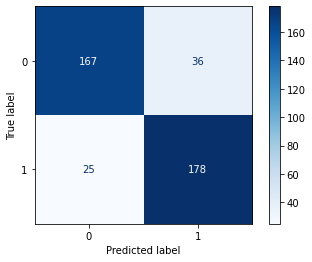

In [269]:
metrics_and_plot_cm(gs_cvec_bag,X_test, y_test)

#### Using TFIDFVectorizer with Bagging

In [270]:
pipe_tvec_bag = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('bag', BaggingClassifier(bootstrap=True))
])

In [271]:
# pipe_bag_params = {
#     'tvec__max_features': [None,2000,3000,4000,5000],
#     'tvec__min_df': [.2,.3],
#     'tvec__max_df': [.85,.9,.95],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'bag__n_estimators': [10,20,30],
# }

# Best params found
pipe_tvec_bag_params = {
    'tvec__max_features': [None],
     'tvec__min_df': [.01],
     'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,1)],
    'bag__n_estimators': [40],
}

In [272]:
gs_tvec_bag = GridSearchCV(estimator = pipe_tvec_bag,
                      param_grid=pipe_tvec_bag_params,
                      cv=5,
#                       verbose=1
                     )

In [273]:
%%time
gs_tvec_bag.fit(X_train, y_train)

Wall time: 20.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [274]:
gs_tvec_bag.best_params_

{'bag__n_estimators': 40,
 'tvec__max_df': 0.95,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [275]:
gs_tvec_bag.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.95, min_df=0.01,
                                 stop_words=['find', 'meanwhile', 'hereupon',
                                             'over', 'everyone', 'twelve',
                                             'throughout', 'most', 'and',
                                             'made', 'keep', 'beforehand',
                                             'ourselves', 'show', 'whereby',
                                             'fill', 'his', 'is', 'hereafter',
                                             'somewhere', 'formerly', 'put',
                                             'more', 'indeed', 'these',
                                             'became', 'former', 'get', 'give',
                                             'whence', ...])),
                ('bag', BaggingClassifier(n_estimators=40))])

In [276]:
gs_tvec_bag.best_score_

0.8312877492877494

In [277]:
gs_tvec_bag.score(X_train, y_train)

0.999384236453202

In [278]:
gs_tvec_bag.score(X_test, y_test)

0.8423645320197044

,Metric,Score
0,Accuracy,0.842365
1,Misclassification Rate,0.157635
2,Sensitivity,0.901478
3,Specificity,0.783251
4,Precision,0.806167


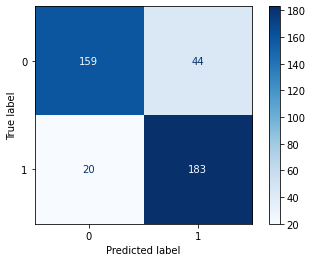

In [279]:
metrics_and_plot_cm(gs_tvec_bag,X_test, y_test)

#### CountVectorizer with RandomForest Classifier

In [280]:
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier()),
])

In [281]:
pipe_cvec_rf_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,1)],
    'rf__n_estimators':[200],
    'rf__max_depth':  [None],
}

In [282]:
gs_cvec_rf = GridSearchCV(estimator=pipe_cvec_rf,
                     param_grid=pipe_cvec_rf_params,
                     cv=5,
#                      verbose=1
                    )

In [283]:
%%time
gs_cvec_rf.fit(X_train, y_train)

Wall time: 5.78 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [284]:
gs_cvec_rf.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 3000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__n_estimators': 200}

In [285]:
gs_cvec_rf.best_score_

0.8645318138651472

In [286]:
gs_cvec_rf.score(X_train, y_train)

0.999384236453202

In [287]:
gs_cvec_rf.score(X_test, y_test)

0.874384236453202

,Metric,Score
0,Accuracy,0.874384
1,Misclassification Rate,0.125616
2,Sensitivity,0.906404
3,Specificity,0.842365
4,Precision,0.851852


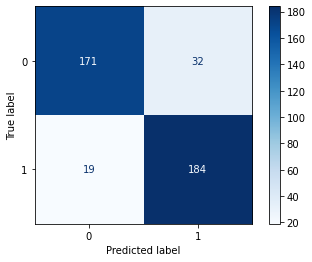

In [288]:
metrics_and_plot_cm(gs_cvec_rf,X_test, y_test)

#### Using TFIDFVectorizer with Random Forest Classifier

In [289]:
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=list_of_stopwords)),
    ('rf', RandomForestClassifier()),
])

In [290]:
# pipe_rf_params = {
#     'tvec__max_features': [None,2000,3000],
#     'tvec__min_df': [.2,.3],
#     'tvec__ngram_range': [(1,1),(1,2),(1,3)],
#     'rf__n_estimators':[100,150,200],
#     'rf__max_depth': [None, 1, 2, 3],
# }

# Best params for Random Forest
pipe_tvec_rf_params = {
    'tvec__max_features': [4000],
    'tvec__min_df': [.01],
#     'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,2)],
    'rf__n_estimators':[150],
    'rf__max_depth':  [None],
}

In [291]:
gs_tvec_rf = GridSearchCV(estimator=pipe_tvec_rf,
                     param_grid=pipe_tvec_rf_params,
                     cv=5,
#                      verbose=1
                    )

In [292]:
%%time
gs_tvec_rf.fit(X_train, y_train)

Wall time: 6.36 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['find',
                                                                    'meanwhile',
                                                                    'hereupon',
                                                                    'over',
                                                                    'everyone',
                                                                    'twelve',
                                                                    'throughout',
                                                                    'most',
                                                                    'and',
                                                                    'made',
                                                                    'keep',
                                                                    'beforeha

In [293]:
gs_tvec_rf.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 150,
 'tvec__max_features': 4000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [294]:
gs_tvec_rf.best_score_

0.8713048433048434

In [295]:
gs_tvec_rf.score(X_train, y_train)

0.999384236453202

In [296]:
gs_tvec_rf.score(X_test, y_test)

0.896551724137931

,Metric,Score
0,Accuracy,0.896552
1,Misclassification Rate,0.103448
2,Sensitivity,0.916256
3,Specificity,0.876847
4,Precision,0.881517


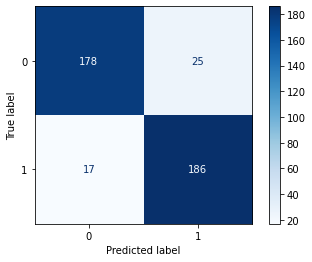

In [297]:
metrics_and_plot_cm(gs_tvec_rf,X_test, y_test)

#### CountVectorizer with ExtraTreesClassifier

In [298]:
pipe_cvec_et = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier()),
])

In [299]:
pipe_cvec_et_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [.01],
    'cvec__max_df': [.95],
    'cvec__ngram_range': [(1,2)],
    'et__n_estimators':[500],
    'et__max_depth':  [None],
}

In [300]:
gs_cvec_et = GridSearchCV(pipe_cvec_et, param_grid=pipe_cvec_et_params,cv=5,verbose=1)

In [301]:
%%time
gs_cvec_et.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 20.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('et', ExtraTreesClassifier())]),
             param_grid={'cvec__max_df': [0.95], 'cvec__max_features': [None],
                         'cvec__min_df': [0.01], 'cvec__ngram_range': [(1, 2)],
                         'et__max_depth': [None], 'et__n_estimators': [500]},
             verbose=1)

In [302]:
gs_cvec_et.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': None,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 2),
 'et__max_depth': None,
 'et__n_estimators': 500}

In [303]:
gs_cvec_et.best_score_

0.943346628679962

In [304]:
gs_cvec_et.score(X_train, y_train)

1.0

In [305]:
gs_cvec_et.score(X_test, y_test)

0.9556650246305419

,Metric,Score
0,Accuracy,0.955665
1,Misclassification Rate,0.044335
2,Sensitivity,0.965517
3,Specificity,0.945813
4,Precision,0.946860


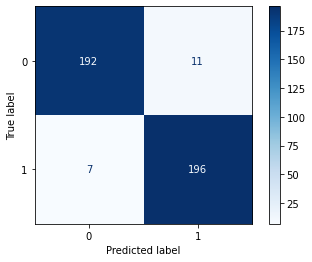

In [306]:
metrics_and_plot_cm(gs_cvec_et,X_test, y_test)

#### TFIDFVectorizer with ExtraTreesClassifier

In [307]:
pipe_tvec_et = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier()),
])

In [308]:
pipe_tvec_et_params = {
    'tvec__max_features': [None],
    'tvec__min_df': [.01],
    'tvec__max_df': [.95],
    'tvec__ngram_range': [(1,1)],
    'et__n_estimators':[600],
    'et__max_depth':  [None],
}

In [309]:
gs_tvec_et = GridSearchCV(pipe_tvec_et, param_grid=pipe_tvec_et_params,cv=5,verbose=1)

In [310]:
%%time
gs_tvec_et.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 20.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('et', ExtraTreesClassifier())]),
             param_grid={'et__max_depth': [None], 'et__n_estimators': [600],
                         'tvec__max_df': [0.95], 'tvec__max_features': [None],
                         'tvec__min_df': [0.01],
                         'tvec__ngram_range': [(1, 1)]},
             verbose=1)

In [311]:
gs_tvec_et.best_params_

{'et__max_depth': None,
 'et__n_estimators': 600,
 'tvec__max_df': 0.95,
 'tvec__max_features': None,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 1)}

In [312]:
gs_tvec_et.best_score_

0.9550560303893636

In [313]:
gs_tvec_et.score(X_train, y_train)

1.0

In [314]:
gs_tvec_et.score(X_test, y_test)

0.9605911330049262

,Metric,Score
0,Accuracy,0.960591
1,Misclassification Rate,0.039409
2,Sensitivity,0.965517
3,Specificity,0.955665
4,Precision,0.956098


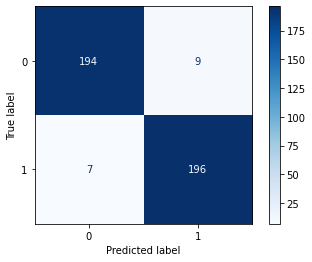

In [315]:
metrics_and_plot_cm(gs_tvec_et,X_test, y_test)